# Analyse exploratoire des données audio et texte (EDA)

A62 Projet de synthèse - Groupe 1208<br>
Gabriel Trottier<br>
Guy Raymond<br>
Philip Gaudreau<br>

In [2]:
import os
import re
import string
import glob
import nltk

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from nltk.corpus import stopwords
from collections import Counter
from nltk import word_tokenize
from wordcloud import WordCloud, ImageColorGenerator



## Répertoires des données

In [3]:
text_dir = "../data/raw/text"
labels_dir =  "../data/raw/labels"
audio_dir = "../data/raw/audio"
#audio_clips_dir = "../data/temp/audio_clips"


## Création d'un DataFrame avec tous les labels

In [4]:
label_files = glob.glob(f"{labels_dir}/*.csv")

df_list = []

for filename in label_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    df_list.append(df)


df_labels = pd.concat(df_list, axis=0, ignore_index=True)

print(f"Shape des données : {(df_labels.shape[0], df_labels.shape[1])} \n ")
print(f"Noms des colonnes : \n {df_labels.columns.to_list()} \n ")
print(f"Nombre de phrases uniques : {len(df_labels['AssignmentId'].unique())}")

Shape des données : (70806, 43) 
 
Noms des colonnes : 
 ['HITId', 'HITTypeId', 'Title', 'Description', 'Keywords', 'Reward', 'CreationTime', 'MaxAssignments', 'RequesterAnnotation', 'AssignmentDurationInSeconds', 'AutoApprovalDelayInSeconds', 'Expiration', 'NumberOfSimilarHITs', 'LifetimeInSeconds', 'AssignmentId', 'WorkerId', 'AssignmentStatus', 'AcceptTime', 'SubmitTime', 'AutoApprovalTime', 'ApprovalTime', 'RejectionTime', 'RequesterFeedback', 'WorkTimeInSeconds', 'LifetimeApprovalRate', 'Last30DaysApprovalRate', 'Last7DaysApprovalRate', 'Input.VIDEO_ID', 'Input.CLIP', 'Answer.anger', 'Answer.disgust', 'Answer.fear', 'Answer.gender', 'Answer.happiness', 'Answer.sadness', 'Answer.secret_word1', 'Answer.secret_word2', 'Answer.secret_word3', 'Answer.sentiment', 'Answer.surprise', 'Answer.video_load', 'Approve', 'Reject'] 
 
Nombre de phrases uniques : 70806


>70 000 entrées, 43 features mais la majorité ne risque pas d'être utile pour nos modèles ou analyse.

### Noms de colonnes plus faciles à utiliser

In [5]:
label_cols = ['Input.VIDEO_ID', 'Input.CLIP',
              'Answer.anger', 'Answer.disgust',
              'Answer.fear', 'Answer.happiness',
              'Answer.sadness', 'Answer.surprise',
              'Answer.sentiment']

label_new_cols = ['file_id', 'clip_id',
                  'anger', 'disgust',
                  'fear', 'happiness',
                  'sadness', 'surprise',
                  'sentiment']

In [6]:
df_labels = df_labels[label_cols]
df_labels.columns = label_new_cols
df_labels.head(5)

,file_id,clip_id,anger,disgust,fear,happiness,sadness,surprise,sentiment
0,xSCvspXYU9k,5,0.0,1.0,0.0,0.0,0.0,0.0,-2.0
1,xSCvspXYU9k,5,0.0,0.0,0.0,0.0,1.0,1.0,-1.0
2,xSCvspXYU9k,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,_UNQDdiAbWI,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,_UNQDdiAbWI,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


Annotation des sentiments :  https://nlp.stanford.edu/~socherr/EMNLP2013_RNTN.pdf

### Affichage des noms de identifiants de fichiers contenant des '/'

Plusieurs entrées dans le dataframe incluent le nom des datasets desquelles les clips proviennent, mais les noms des fichiers audios ou textes ne les contiennent pas.


In [21]:
df_labels[df_labels.anger == 1]

,file_id,clip_id,anger,disgust,fear,happiness,sadness,surprise,sentiment
12,mSWwz7dXUP8,6,1.0,1.0,0.0,1.0,1.0,0.0,2.0
78,xnNZyfhusAk,9,1.0,1.0,1.0,0.0,3.0,0.0,-2.0
79,xnNZyfhusAk,9,1.0,2.0,0.0,0.0,0.0,0.0,-2.0
102,BdqoZ5qpz0E,13,1.0,0.0,0.0,0.0,0.0,0.0,-1.0
128,7xiu1tAJ2d8,16,1.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
70687,139006,10,1.0,1.0,0.0,0.0,0.0,0.0,-3.0
70688,139006,10,1.0,0.0,0.0,0.0,0.0,0.0,-2.0
70718,5OUcvUDMMWE,3,1.0,0.0,0.0,0.0,0.0,0.0,3.0
70742,DnBHq5I52LM,5,1.0,0.0,0.0,0.0,0.0,0.0,-2.0


In [7]:
df_labels[df_labels['file_id'].apply(lambda x : '/' in str(x))].tail(10)

,file_id,clip_id,anger,disgust,fear,happiness,sadness,surprise,sentiment
70796,pom_extra/216007,16,0.0,0.0,0.0,0.0,0.0,0.0,0.0
70797,sqa_mosi/32j1yMF37hA,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0
70798,sqa_mosi/32j1yMF37hA,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0
70799,sqa_mosi/32j1yMF37hA,1,0.0,0.0,0.0,1.0,0.0,0.0,1.0
70800,sqa_mosi/DbAppk7xT0Y,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0
70801,sqa_mosi/DbAppk7xT0Y,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0
70802,sqa_mosi/DbAppk7xT0Y,7,0.0,0.0,0.0,1.0,0.0,0.0,0.0
70803,sqa_mosi/iREkcXde5ds,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0
70804,sqa_mosi/iREkcXde5ds,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0
70805,sqa_mosi/iREkcXde5ds,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Suppression des '/' dans les indentifiants de fichiers pour comparaisons avec audio et textes

In [8]:
df_labels['file_id'] = df_labels['file_id'].map(lambda x : str(x).split("/")[-1])
df_labels[df_labels['file_id'].apply(lambda x : '/' in str(x))].tail(10)

annotated_files = len(df_labels['file_id'].unique())
print(f"Nombre de textes avec au moins un clip annoté: {annotated_files}")

Nombre de textes avec au moins un clip annoté: 3305


Il y a plus de 3800 textes/fichiers audios, donc au moins 500 ne sont pas du tout annotés dans les labels

## Extraction des informations des clips audio des fichiers texte

À partir des labels et des fichiers audio, on extrait la durée de chaque clip annoté

In [9]:
def get_audio_info_from_text(text_dir):
    '''
        get audio information from text files to extract clips
        - clip number
        - clip start time
        - clip end time
        return DataFrame
    '''
    text_files = glob.glob(f"{text_dir}/*.txt")
    df_list = []
    for file in text_files:
        with open(file, 'r') as text_file:
            text_lines = text_file.readlines()
            #df_text = pd.DataFrame()
            text_dict_list = []
            for text_line in text_lines:
                line_dict = {}
                split_line = text_line.split('___')
                line_dict['file_id'] = split_line[0]
                line_dict['clip_id'] = int(split_line[1])
                line_dict['start_time'] = abs(float(split_line[2]))
                line_dict['end_time'] = float(split_line[3])
                
                # leave text out for now
                # line_dict['text'] = split_line[4][:-1]
                
                text_dict_list.append(line_dict)
        df_list.append(pd.DataFrame(text_dict_list))
    df = pd.concat(df_list, axis=0, ignore_index=True)
    return df

## Fichiers bruts

In [10]:
'''
audio_info = get_audio_info_from_text(text_dir)
print(f"Nombre de fichiers audio/textes                  : ",
      f"{len(audio_info['file_id'].unique())}")
print(f"Nombre de clips (phrases) extraits des textes    : {audio_info.shape[0]}")
print(f"Nombre de clips (phrases) moyen par fichier texte:   ",
      f"{round(audio_info.shape[0]/len(audio_info['file_id'].unique()))}")
      '''

UnicodeDecodeError: 'charmap' codec can't decode byte 0x9d in position 1268: character maps to <undefined>

Informations de base de chaque clip audio

In [ ]:
#audio_info.head()

In [ ]:
'''
#Fonctions pour obtenir/comparer les identifiants de chaque clip audio
def get_audio_file_ids(audio_dir):
    '''
        audio_dir: répertoire contenant les fichiers audio
        retrourne le nom des fichiers du répertoire (sans .wav)
    '''
    file_ids = []
    audio_files = glob.glob(f"{audio_dir}/*.wav")
    for file in audio_files:
        file_ids.append(file.split('/')[-1].split('.')[0])
    return file_ids

def compare_ids(ids_list1, ids_list2):

    ids1_not_in_ids2 = []
    for i in ids_list1:
        if i not in ids_list2:
            ids1_not_in_ids2.append(i)
    return ids1_not_in_ids2
    '''


Avec les ID retrouvés dans les datasets de labels et en les comparants avec les fichiers mêmes, on peut voir ceux qui n'ont aucune annotation associée

In [ ]:
'''
audio_ids = get_audio_file_ids(audio_dir) 

audio_not_in_text = \
    compare_ids(audio_ids, audio_info['file_id'].values)
print("Nombre de fichiers audios n'apparaissant pas dans les textes: ",
      len(audio_not_in_text))
text_not_in_audio = \
    compare_ids(audio_info['file_id'].values, audio_ids)
print(f"Fichiers textes n'apparaissant pas dans les fichiers audio  : ",
      len(text_not_in_audio))
      '''

## Fichiers audio n'étant pas étiquetés (pas dans labels)

In [ ]:
'''
print("Nombre de fichiers audio avant séparation en clips             : ",
      len(audio_ids))
files_not_in_labels = \
    compare_ids(audio_ids, df_labels['file_id'].values)
print("Nombre de fichiers audio n'apparaissant pas dans les labels    :  ",
      len(files_not_in_labels))

files_labeled = len(audio_ids) - len(files_not_in_labels)
print("Nombre de fichiers audio ayant au moins un clip dans les labels: ",
      files_labeled)
      '''

## Calcul de la longueur des clips

In [ ]:
#audio_info['clip_len'] = \
 #   audio_info.apply(lambda x : x['end_time'] - x['start_time'], axis=1)

## DataFrame contenant les clips annotés seulement

In [ ]:
audio_labeled = audio_info.drop(index=no_label_index)
audio_labeled.head()

## Temps total des clips annotés

In [ ]:
def convert_secs(seconds):
    min, sec = divmod(seconds, 60)
    hour, min = divmod(min, 60)
    return "%d:%02d:%02d" % (hour, min, sec)

In [ ]:
tot_clips = audio_info.shape[0]
not_annot_clips = len(no_label_clips)
annot_clips = tot_clips - not_annot_clips
print(f"Nombre total de clips        : {tot_clips}")
print(f"Nombre de clips non-annotés  : {not_annot_clips}")
print(f"Nombre de clips annotés      : {annot_clips}")
print("Pourcentage de clips annotés :",
      f"{round(annot_clips/tot_clips * 100,2)} %")
time_clips_labeled = convert_secs(audio_labeled['clip_len'].sum())
print(f"Temps des clips annotés      : {time_clips_labeled} heures")

#### Nombre de clips par fichiers

In [ ]:
clip_count = audio_info['file_id'].value_counts()

plt.figure(figsize=(16, 7))
plt.title("Distibution du nombre de clips par fichier", fontsize=18)
plt.hist(clip_count, bins=30)
plt.xlim(0, 60)
plt.show()

On voit que la majorité des fichiers ont environ entre 2 et 15 clips, donc le même nombre de phrases uniques. Très peux de fichiers ont jusqu'à 60, puis quelques-uns ayant un nombre très élevé.

#### Fichiers ayants un nombre anormalement élevé de clips

In [ ]:
print(clip_count[clip_count > 50])

#### Longueurs des clips (tous les clips inclus)

In [ ]:
len_bins = 40
plt.figure(figsize=(16, 7))
plt.title("Distibution de la longueur des de clips en secondes", fontsize=18)
plt.hist(audio_info['clip_len'], bins=len_bins)
plt.xlim(0,50)
plt.show()

#### Longueurs des clips annotés

In [ ]:
len_bins = 40
plt.figure(figsize=(16, 7))
plt.title("Distibution de la longueur des de clips annotés en secondes", fontsize=18)
plt.hist(audio_labeled['clip_len'], bins=len_bins)
plt.xlim(0, 50)
plt.show()

In [ ]:
print(f"Longueur moyenne des clips : {audio_info['clip_len'].mean().round(3)} sec.")
print(f"Longueur médiane des clips : {audio_info['clip_len'].median().round(3)} sec.")
print(f"Longueur minimale des clips: {audio_info['clip_len'].min().round(3)} sec.")
print(f"Longueur maximale des clips: {audio_info['clip_len'].max().round(3)} sec.")

Avec une moyenne et une médiane près de 6-7 secondes, on voit que les clips sont bien généralement des phrases normales complètes, qui ne sont pas trop complexe ou qui ne s'étirent pas trop.

Les min et max sont cependant assez extrêmes, aucune phrase complète ne peut durer 0.12 secondes et à plus de 2 minutes pour le max, on a sûrement un paragraphe entier ou de très longues pauses ou problème d'enregistrement.


# EDA  TEXTE

In [11]:
text_files = glob.glob(f"{text_dir}/*.txt")

def remove_stamps_str(line)->str:
    stamp = re.search('.+___', line).group(0)
    new_line = line.strip(stamp)
    return new_line

# Retrait des timestamps

In [12]:
#Retire chaque stamps, chaque texte devien 1 seul str
text_list = []
for filename in text_files:
    text = ''
    with open(file=filename, encoding='utf-8') as f:
        lines = f.readlines()
        for line in lines:
            clean_line = remove_stamps_str(line)
            text += clean_line
    text_list.append(text.splitlines())


In [19]:
print(stop_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

### Fonctions de nettoyage et statistiques

In [13]:
stop_words = stopwords.words('English')

#création d'un dict pour lookup en O(1)
stopwords_dict = Counter(stop_words)


def avg_count(l1:list):
    word_count = 0
    for e in l1:
        word_count += len(e.split())
    return int(word_count/len(l1))

#Retire tous les timestamps en début de ligne, présents dans chaque transcript
def remove_stamps_str(line)->str:
    stamp = re.search('.+___', line).group(0)
    new_line = line.strip(stamp)
    return new_line

#Retire les charactères non-ascii 
def remove_non_ascii(line)->str:
    ascii_line = line.encode(encoding = 'ascii', errors = 'ignore').decode()
    return ascii_line

#met tout en minuscules, retire les nombres et stopwords
def clean_stopwords_digits(line)->str:
    new_line = ' '.join([word.lower() for word in line.split() if (len(word) >=2 and word.isalpha() and word not in stopwords_dict)])
    return new_line

#### Dataframe pour bien visualiser des statistiques simples

In [14]:
df_text = pd.DataFrame((np.array(text_list, dtype= object)).reshape(-1))
df_text.columns = ['raw_text']

#on utilise la librairie NLTK pour sortir que les "tokens"
df_text['tokens'] = df_text['raw_text'].apply(lambda l : word_tokenize(' '.join(l)))

df_text['lines'] = df_text['raw_text'].apply(lambda x : len(x))
df_text['avg_count'] = df_text['raw_text'].apply(avg_count)
df_text['word_count'] = df_text['tokens'].apply(len)
df_text['raw_text'] = df_text['raw_text'].apply(lambda x : ' '.join(x))
df_text['cleaned_text'] = df_text['raw_text'].apply(clean_stopwords_digits)

display(df_text)


,raw_text,tokens,lines,avg_count,word_count,cleaned_text
0,I see that there are three category of writers...,"[I, see, that, there, are, three, category, of...",9,16,165,see three category define story an like classi...
1,"Hi, my name is Raj Shah. I'm from Spectro Coat...","[Hi, ,, my, name, is, Raj, Shah, ., I, 'm, fro...",19,18,414,name raj spectro vice president key polymer br...
2,"Introduction Speaker: Dr. Erma Jean Sims, Sono...","[Introduction, Speaker, :, Dr., Erma, Jean, Si...",6,17,118,introduction erma jean sonoma state university...
3,"This is Rhett Reiger, White Caspian Studios on...","[This, is, Rhett, Reiger, ,, White, Caspian, S...",7,41,317,this rhett white caspian studios behalf expert...
4,This is financial adviser Patrick Munro answer...,"[This, is, financial, adviser, Patrick, Munro,...",11,18,226,this financial adviser patrick munro answering...
...,...,...,...,...,...,...
3832,Hi Guys I just wanted to share my thoughts wit...,"[Hi, Guys, I, just, wanted, to, share, my, tho...",11,18,228,hi guys wanted share thoughts book results stu...
3833,- University of Illinois candidates are very p...,"[-, University, of, Illinois, candidates, are,...",7,19,154,university illinois candidates prepared great ...
3834,"e use both, again, we use Aprimo software inte...","[e, use, both, ,, again, ,, we, use, Aprimo, s...",6,18,129,use use aprimo software internally use and abl...
3835,"Well, I think for us it’s-- the way to leverag...","[Well, ,, I, think, for, us, it, ’, s, --, the...",14,25,418,think us way leverage technology innovation in...


Autre statistique intéressante : la longueur des mots

In [15]:
words_lengths = df_text['tokens'].apply(lambda array : list(map(len, array))).explode()


print(f"Longueur moyenne des mots : ~ {np.ceil(np.mean(words_lengths))}")

Longueur moyenne des mots : ~ 4.0


### Word cloud

In [16]:
wordcount = df_text['cleaned_text'].str.split(expand=True).stack().value_counts()
wordcount

movie         3994
like          3746
really        3734
and           3573
the           2871
              ... 
nosedive         1
frowning         1
detests          1
diligently       1
interplay        1
Length: 21744, dtype: int64

En regardant simplement un petit extrait, il semble que les mots les plus fréquents sont cours, simples et servent soit à donner un opinion/décrire (like, really), ou des sujets (movie), alors que les rares sont plus longs et recherchés.

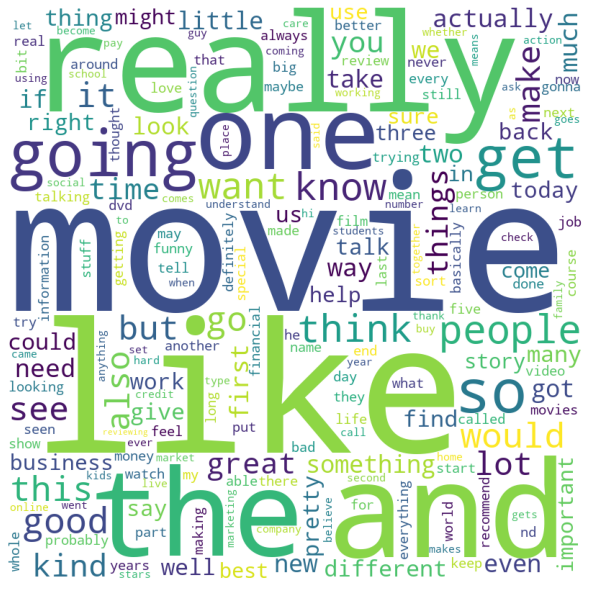

In [17]:
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                
                min_font_size = 10).generate_from_frequencies(wordcount)

plt.figure(figsize = (8, 8))
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

Le wordcloud nous donne une meilleure idée des mots les plus fréquents, on remarque aussi certains mots liés aux affaires/finances comme "financial", "business", "credit".

En effet, les datasets contiennent des clips sur différents sujets, incluant des critiques de films, articles de finances etc comme on peut voir ici.